In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io

In [3]:
!pip install opencv-python


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#STEP1 - Read image and define pixel size
img = cv2.imread("/content/grains1.jpg", 0)

pixels_to_um = 0.5 # (1 px = 500 nm)
# plt.hist(img.flat, bins=100, range=(0,255))


In [6]:
#Change the grey image to binary by thresholding.
ret, thresh = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
# print("Otsu's Threshold Value:", ret)
#  print(ret)  #Gives 157 on grains2.jpg. OTSU determined this to be the best threshold.

In [7]:
#Step 3: Clean up image, if needed (erode, etc.) and create a mask for grains

kernel = np.ones((3,3),np.uint8)
eroded = cv2.erode(thresh,kernel,iterations = 1)
dilated = cv2.dilate(eroded,kernel,iterations = 1)

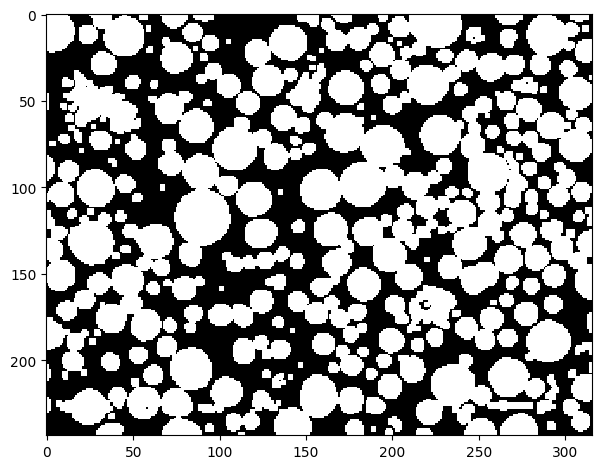

In [8]:
# Now, we need to apply threshold, meaning convert uint8 image to boolean.
mask = dilated == 255  #Sets TRUE for all 255 valued pixels and FALSE for 0
#print(mask)   #Just to confirm the image is not inverted.

#from skimage.segmentation import clear_border
#mask = clear_border(mask)   #Removes edge touching grains.

io.imshow(mask)  #cv2.imshow() not working on boolean arrays so using io
#io.imshow(mask[250:280, 250:280])   #Zoom in to see pixelated binary image

In [9]:
# 4 connectivity would be [[0,1,0],[1,1,1],[0,1,0]]
s = [[1,1,1],[1,1,1],[1,1,1]]
#label_im, nb_labels = ndimage.label(mask)
labeled_mask, num_labels = ndimage.label(mask, structure=s)

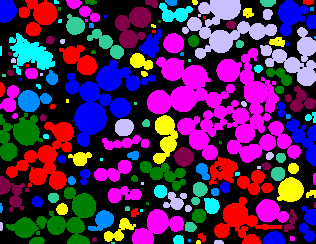

True

In [10]:


from google.colab.patches import cv2_imshow
import cv2
from skimage import color

# Assuming labeled_mask is your labeled image array

# Convert labeled mask to RGB color image
img2 = color.label2rgb(labeled_mask, bg_label=0)

# Convert image data type to uint8 (8-bit unsigned integer)
img2_uint8 = (img2 * 255).astype('uint8')

# Display the colored image
cv2_imshow(img2_uint8)

# Continue with your code
# Save the image
cv2.imwrite('/content/grains2.jpg', cv2.cvtColor(img2_uint8, cv2.COLOR_RGB2BGR))

In [11]:
#View just by making mask=threshold and also mask = dilation (after morph operations)
#Some grains are well separated after morph operations

#Now each object had a unique number in the image.
#Total number of labels found are...
#print(num_labels)

#Step 5: Measure the properties of each grain (object)

# regionprops function in skimage measure module calculates useful parameters for each object.

clusters = measure.regionprops(labeled_mask, img)  #send in original image for Intensity measurements



In [12]:
#The output of the function is a list of object properties.

#Test a few measurements
#print(clusters[0].perimeter)

#Can print various parameters for all objects
for prop in clusters:
   print('Label: {} Area: {}'.format(prop.label, prop.area))

#Step 6: Output results into a csv file
#Best way is to output all properties to a csv file



Label: 1 Area: 327
Label: 2 Area: 814
Label: 3 Area: 18
Label: 4 Area: 109
Label: 5 Area: 49
Label: 6 Area: 80
Label: 7 Area: 59
Label: 8 Area: 26
Label: 9 Area: 2194
Label: 10 Area: 94
Label: 11 Area: 779
Label: 12 Area: 49
Label: 13 Area: 369
Label: 14 Area: 182
Label: 15 Area: 12
Label: 16 Area: 891
Label: 17 Area: 16
Label: 18 Area: 83
Label: 19 Area: 89
Label: 20 Area: 289
Label: 21 Area: 9
Label: 22 Area: 9
Label: 23 Area: 15
Label: 24 Area: 9
Label: 25 Area: 9
Label: 26 Area: 65
Label: 27 Area: 24
Label: 28 Area: 16
Label: 29 Area: 1354
Label: 30 Area: 427
Label: 31 Area: 349
Label: 32 Area: 12
Label: 33 Area: 937
Label: 34 Area: 327
Label: 35 Area: 106
Label: 36 Area: 61
Label: 37 Area: 6
Label: 38 Area: 114
Label: 39 Area: 22
Label: 40 Area: 53
Label: 41 Area: 15
Label: 42 Area: 622
Label: 43 Area: 20
Label: 44 Area: 7557
Label: 45 Area: 18
Label: 46 Area: 15
Label: 47 Area: 15
Label: 48 Area: 254
Label: 49 Area: 23
Label: 50 Area: 9
Label: 51 Area: 2946
Label: 52 Area: 9
Labe

In [13]:
propList = ['Area',
            'equivalent_diameter', #Added... verify if it works
            'orientation', #Added, verify if it works. Angle btwn x-axis and major axis.
            'MajorAxisLength',
            'MinorAxisLength',
            'Perimeter',
            'MinIntensity',
            'MeanIntensity',
            'MaxIntensity']

output_file = open('image_measurements.csv', 'w')
output_file.write(',' + ",".join(propList) + '\n')





120

In [14]:


for cluster_props in clusters:
    # Output cluster properties to the excel file
    output_file.write(str(cluster_props['Label']))
    for i, prop in enumerate(propList):
        if prop == 'Area':
            to_print = cluster_props[prop] * pixels_to_um**2   # Convert pixel square to um square
        elif prop == 'orientation':
            to_print = cluster_props[prop] * 57.2958            # Convert to degrees from radians
        elif 'Intensity' not in prop:                          # Any prop without Intensity in its name
            to_print = cluster_props[prop] * pixels_to_um
        else:
            # Handle intensity-related properties separately based on the intensity values within the region
            # For example, you can calculate min, mean, and max intensities within the region
            # Here, we'll simply assign a placeholder value (you may need to replace this)
            to_print = -1
        output_file.write(',' + str(to_print))
    output_file.write('\n')

output_file.close()   # Closes the file, otherwise, it would be read-only
